# Credit Card Fraud Detection - Data Preprocessing

## Table of Contents

1. <a href="#1-import">Import</a>
2. <a href="#2-load-dataset">Load dataset</a>
3. <a href="#3-detect-outliers">Detect Outliers</a>
    - 3.1. <a href="#31-using-the-iqr-method">Using the IQR Method</a>
    - 3.2. <a href="#32-using-z-score-method">Using Z-score Method</a>
4. <a href="#4-normalization--standardization">Normalization & Standardization</a>
    - 4.1. <a href="#41-min-max-normalization">Min-Max Normalization</a>
    - 4.2. <a href="#42-z-score-standardization">Z-score Standardization</a>
    - 4.3. <a href="#43-log-transformation">Log Transformation</a>
    - 4.4. <a href="#44-decimal-scaling">Decimal Scaling</a>
5. <a href="#6-train-test-split">Train-Test Split</a>

## 1. Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)

## 2. Load dataset

In [3]:
file_path = '../data/raw/creditcard.csv'
data_str = np.genfromtxt(file_path, dtype=str, delimiter=',')

data_str = np.char.strip(data_str, '"')
header = data_str[0]
data_str = data_str[1:]
data = data_str.astype(np.float64)

X = data[:, :-1]
y = data[:, -1].astype(int)

## 3. Detect Outliers

### 3.1. Using the IQR Method

In [4]:
q1 = np.percentile(X, 25, axis=0)
q3 = np.percentile(X, 75, axis=0)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outlier_mask_iqr = (X < lower_bound) | (X > upper_bound)

outlier_counts_iqr = np.sum(outlier_mask_iqr, axis=0)
print(f"Total number of outliers: {np.sum(outlier_mask_iqr):,}")
print(f"Outliers ratio: {np.sum(outlier_mask_iqr) / X.size * 100:.2f}%")

top_outlier_indices = np.argsort(outlier_counts_iqr)[::-1][:5]
print(f"\nTop 5 features with the most outliers:")
for idx in top_outlier_indices:
    print(f"  {header[idx]}: {outlier_counts_iqr[idx]:,} outliers ({outlier_counts_iqr[idx]/X.shape[0]*100:.2f}%)")
    print(f"    Q1 ={q1[idx]:8.2f}, Q3 ={q3[idx]:8.2f}, IQR ={iqr[idx]:8.2f}")
    print(f"    Lower bound ={lower_bound[idx]:8.2f}, Upper bound ={upper_bound[idx]:8.2f}")

Total number of outliers: 370,372
Outliers ratio: 4.33%

Top 5 features with the most outliers:
  V27: 39,163 outliers (13.75%)
    Q1 =   -0.07, Q3 =    0.09, IQR =    0.16
    Lower bound =   -0.31, Upper bound =    0.33
  Amount: 31,904 outliers (11.20%)
    Q1 =    5.60, Q3 =   77.16, IQR =   71.56
    Lower bound = -101.75, Upper bound =  184.51
  V28: 30,342 outliers (10.65%)
    Q1 =   -0.05, Q3 =    0.08, IQR =    0.13
    Lower bound =   -0.25, Upper bound =    0.28
  V20: 27,770 outliers (9.75%)
    Q1 =   -0.21, Q3 =    0.13, IQR =    0.34
    Lower bound =   -0.73, Upper bound =    0.65
  V8: 24,134 outliers (8.47%)
    Q1 =   -0.21, Q3 =    0.33, IQR =    0.54
    Lower bound =   -1.01, Upper bound =    1.13


### Phát hiện và xử lý ngoại lai (Outliers)
Dữ liệu gian lận tài chính thường chứa nhiều nhiễu và giá trị ngoại lai. Việc xác định các điểm dữ liệu này giúp chúng ta hiểu rõ hơn về phân phối dữ liệu, tuy nhiên trong bài toán này, ngoại lai có thể chính là các giao dịch gian lận mà chúng ta cần tìm.

**Phương pháp 1: IQR (Interquartile Range)**
* **Kết quả:** Phương pháp IQR xác định được **370,372** điểm dữ liệu là ngoại lai (tính trên tổng số tất cả các ô dữ liệu của ma trận X, chiếm khoảng **4.33%**).
* **Các đặc trưng có nhiều ngoại lai nhất:**
    * `V27`, `Amount`, `V28`, `V20`, `V8` là những đặc trưng có tỷ lệ ngoại lai cao nhất (lên đến 13.75% đối với V27).
    * Đặc biệt cột `Amount` có dải giá trị rất rộng (từ -101.75 đến 184.51 cho khoảng chấp nhận IQR, trong khi giá trị thực tế lên đến hàng chục nghìn), khẳng định lại sự cần thiết phải chuẩn hóa biến này.

### 3.2. Using Z-score Method

In [5]:
threshold = 3.0

mean_vals = np.mean(X, axis=0, keepdims=True)
std_vals = np.std(X, axis=0, ddof=1, keepdims=True)

std_vals = np.where(std_vals == 0, 1, std_vals)

z_scores = (X - mean_vals) / std_vals

outlier_mask_zscore = np.abs(z_scores) > threshold

outlier_counts_zscore = np.sum(outlier_mask_zscore, axis=0)

print(f"Threshold: {threshold}")
print(f"Total number of outliers: {np.sum(outlier_mask_zscore):,}")
print(f"Outliers ratio: {np.sum(outlier_mask_zscore) / X.size * 100:.2f}%")

top_outlier_indices_z = np.argsort(outlier_counts_zscore)[::-1][:10]
print(f"\nTop 10 features with the most outliers:")
for idx in top_outlier_indices_z:
    max_z = np.max(np.abs(z_scores[:, idx]))
    print(f"  {header[idx]}: {outlier_counts_zscore[idx]:,} outliers ({outlier_counts_zscore[idx]/X.shape[0]*100:.2f}%)")
    print(f"    Max |Z-score|: {max_z:.2f}")


Threshold: 3.0
Total number of outliers: 83,598
Outliers ratio: 0.98%

Top 10 features with the most outliers:
  V27: 4,771 outliers (1.68%)
    Max |Z-score|: 78.32
  V6: 4,652 outliers (1.63%)
    Max |Z-score|: 55.02
  V20: 4,645 outliers (1.63%)
    Max |Z-score|: 70.69
  V2: 4,318 outliers (1.52%)
    Max |Z-score|: 44.04
  V8: 4,221 outliers (1.48%)
    Max |Z-score|: 61.30
  Amount: 4,076 outliers (1.43%)
    Max |Z-score|: 102.36
  V21: 4,064 outliers (1.43%)
    Max |Z-score|: 47.42
  V1: 3,701 outliers (1.30%)
    Max |Z-score|: 28.80
  V10: 3,488 outliers (1.22%)
    Max |Z-score|: 22.58
  V7: 3,401 outliers (1.19%)
    Max |Z-score|: 97.48


**Phương pháp 2: Z-score**
* Sử dụng ngưỡng (threshold) = 3, tức là các điểm dữ liệu nằm ngoài khoảng ($\mu \pm 3\sigma$).
* **Kết quả:** Phát hiện ít ngoại lai hơn so với IQR (**83,598** điểm, chiếm **0.98%**).
* **Các đặc trưng nổi bật:** `V27`, `V6`, `V20`, `V2` có số lượng ngoại lai lớn.
* **Quan sát quan trọng:** Giá trị Max |Z-score| của `Amount` lên tới **102.36**, cho thấy có những giao dịch với số tiền cực kỳ lớn so với mức trung bình, một dấu hiệu rất đáng ngờ.

**Quyết định xử lý ngoại lai:**
Trong bài toán phát hiện gian lận (Fraud Detection), **chúng ta KHÔNG loại bỏ các ngoại lai này**. Lý do:
1.  Các giao dịch gian lận thường có hành vi khác biệt so với giao dịch thường (ví dụ: số tiền lớn bất thường, thời gian giao dịch lạ).
2.  Loại bỏ ngoại lai có thể vô tình loại bỏ chính những mẫu gian lận (Fraud cases) mà mô hình cần học để phát hiện.
3.  Thay vào đó, chúng ta sẽ sử dụng các phương pháp chuẩn hóa mạnh (Robust Scaler) hoặc các mô hình cây quyết định (Decision Trees/Random Forest/XGBoost) có khả năng chịu nhiễu tốt.

## 4. Normalization & Standardization

Do các đặc trưng có đơn vị và dải giá trị khác nhau (ví dụ: `Amount` có thể lên tới hàng nghìn, trong khi `V1-V28` đã được PCA), việc đưa chúng về cùng một thang đo là cần thiết, đặc biệt với các thuật toán dựa trên khoảng cách (như KNN, SVM) hoặc mạng nơ-ron.

### 4.1. Min-Max Normalization

Feature range: (0, 1)
Original data range: [-113.743306711146, 172792.0]
Normalized data range: [0.0, 1.0]


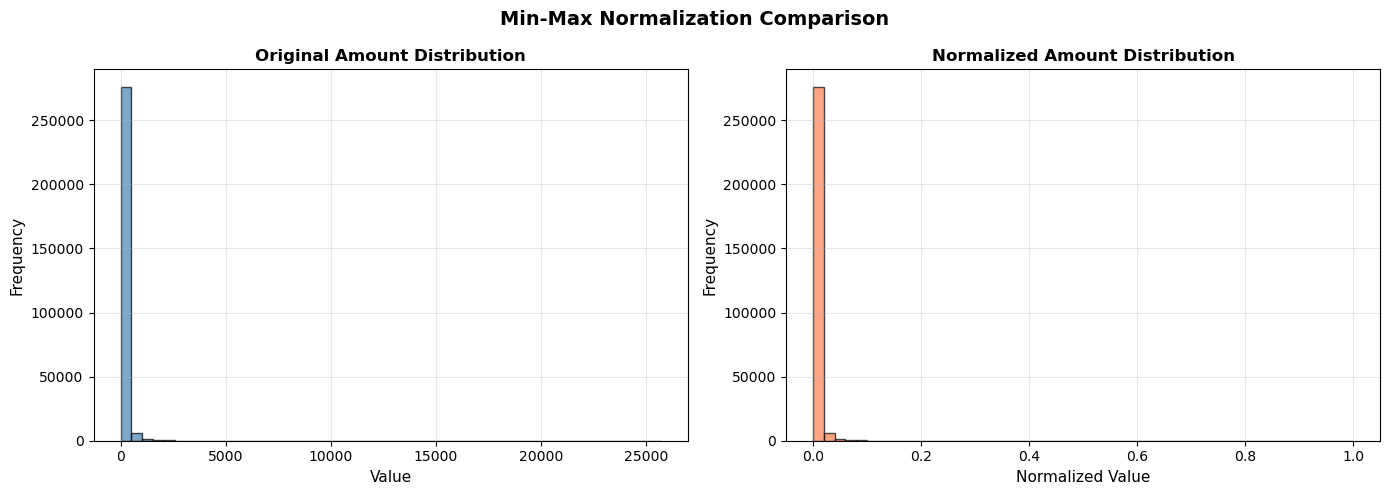

In [6]:
feature_range = (0, 1)
min_range, max_range = feature_range

min_vals = np.min(X, axis=0, keepdims=True)
max_vals = np.max(X, axis=0, keepdims=True)

range_vals = max_vals - min_vals
range_vals = np.where(range_vals == 0, 1, range_vals)

X_normalized = (X - min_vals) / range_vals * (max_range - min_range) + min_range
X_normalized = np.clip(X_normalized, min_range, max_range)

print(f"Feature range: {feature_range}")
print(f"Original data range: [{np.min(X)}, {np.max(X)}]")
print(f"Normalized data range: [{np.min(X_normalized)}, {np.max(X_normalized)}]")

feature_idx = np.where(header == 'Amount')[0][0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(X[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Original {header[feature_idx]} Distribution', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(X_normalized[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[1].set_xlabel('Normalized Value', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Normalized {header[feature_idx]} Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.suptitle('Min-Max Normalization Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**So sánh phương pháp 1: Min-Max Normalization**
* Đưa dữ liệu về khoảng [0, 1].
* **Kết quả:** Biểu đồ cho thấy hình dạng phân phối (distribution shape) của `Amount` được giữ nguyên, chỉ thay đổi trục hoành (x-axis). Tuy nhiên, do ảnh hưởng của các giá trị ngoại lai cực lớn, phần lớn dữ liệu bị dồn (squashed) về gần giá trị 0, làm mất đi độ chi tiết của các giao dịch nhỏ.

### 4.2. Z-score Standardization

Original data - Mean: 3163.4069731443824, Std: 19100.297923063987
Standardized data - Mean: 7.893716227671327e-15, Std: 0.9999983029426932


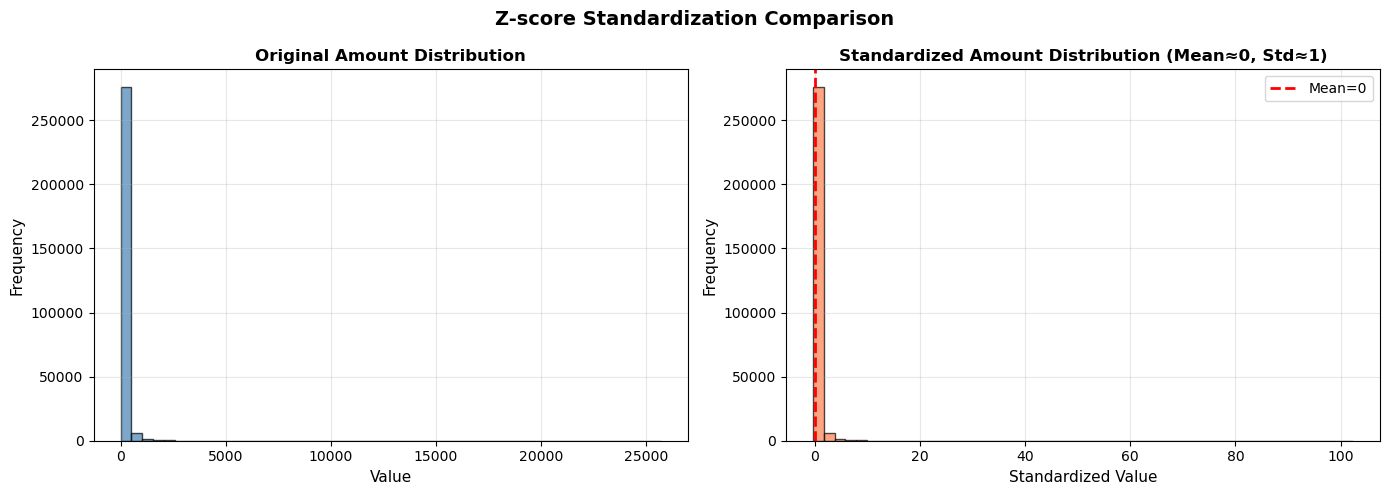

In [7]:
X_standardized = (X - mean_vals) / std_vals

print(f"Original data - Mean: {np.mean(X)}, Std: {np.std(X, ddof=1)}")
print(f"Standardized data - Mean: {np.mean(X_standardized)}, Std: {np.std(X_standardized, ddof=1)}")

feature_idx = np.where(header == 'Amount')[0][0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(X[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Original {header[feature_idx]} Distribution', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(X_standardized[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[1].set_xlabel('Standardized Value', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Standardized {header[feature_idx]} Distribution (Mean≈0, Std≈1)', 
                 fontsize=12, fontweight='bold')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.suptitle('Z-score Standardization Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**So sánh phương pháp 2: Z-score Standardization**
* Đưa dữ liệu về phân phối chuẩn tắc với Mean = 0 và Std = 1.
* **Kết quả:** Biểu đồ bên phải cho thấy dữ liệu được căn giữa tại 0. Tuy nhiên, giống như Min-Max, Z-score cũng chịu ảnh hưởng mạnh bởi ngoại lai. Dải giá trị sau khi chuẩn hóa vẫn rất rộng (từ -0.35 đến hơn 100), chưa thực sự giải quyết được vấn đề lệch phân phối (skewness).

### 4.3. Log Transformation

Original Amount - Mean: 88.35, Std: 250.12
Log-transformed Amount - Mean: 3.1522, Std: 1.6566

Skewness - Before: 16.9775, After: 0.1627
Skewness reduction: 16.8148


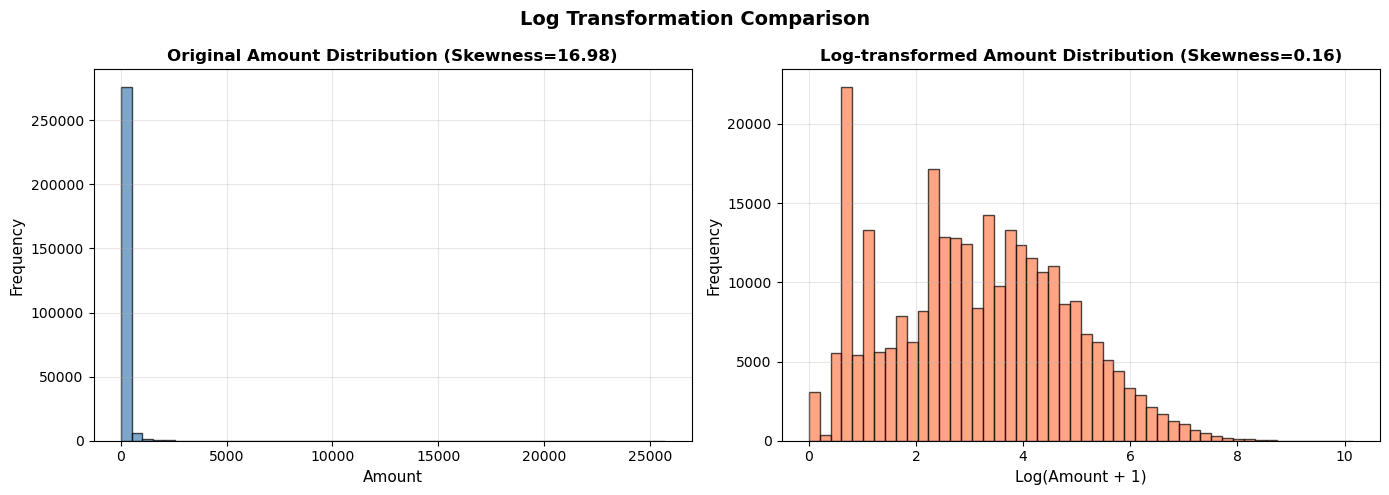

In [8]:
amount_idx = np.where(header == 'Amount')[0][0]

X_log_amount = X.copy()
X_log_amount[:, amount_idx] = np.log1p(X[:, amount_idx]) 

print(f"Original Amount - Mean: {np.mean(X[:, amount_idx]):.2f}, Std: {np.std(X[:, amount_idx], ddof=1):.2f}")
print(f"Log-transformed Amount - Mean: {np.mean(X_log_amount[:, amount_idx]):.4f}, Std: {np.std(X_log_amount[:, amount_idx], ddof=1):.4f}")

def calculate_skewness_simple(data):
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    if std == 0:
        return 0
    centered = data - mean
    skew = np.mean((centered / std) ** 3)
    return skew

skew_before = calculate_skewness_simple(X[:, amount_idx])
skew_after = calculate_skewness_simple(X_log_amount[:, amount_idx])
print(f"\nSkewness - Before: {skew_before:.4f}, After: {skew_after:.4f}")
print(f"Skewness reduction: {abs(skew_before) - abs(skew_after):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(X[:, amount_idx], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Amount', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Original Amount Distribution (Skewness={skew_before:.2f})', 
                 fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(X_log_amount[:, amount_idx], bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[1].set_xlabel('Log(Amount + 1)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Log-transformed Amount Distribution (Skewness={skew_after:.2f})', 
                 fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.suptitle('Log Transformation Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**So sánh phương pháp 3: Log Transformation (Logarit hóa)**
Đây là kỹ thuật quan trọng để xử lý các biến có phân phối lệch phải (right-skewed) như `Amount`.
* Sử dụng công thức: $x_{new} = \ln(x + 1)$.

**Kết quả:**
* **Giảm độ lệch (Skewness reduction):** Độ lệch giảm mạnh từ **16.98** xuống còn **0.16**.
* **Phân phối:** Biểu đồ bên phải (màu cam) cho thấy sau khi Log-transform, phân phối của `Amount` đã trở nên cân đối hơn rất nhiều, gần với phân phối chuẩn (hình chuông). Điều này giúp các mô hình học máy (đặc biệt là Linear Regression, Logistic Regression, Neural Networks) học tốt hơn.

**-> Quyết định:** Chúng ta sẽ áp dụng **Log Transformation** cho cột `Amount` trước khi thực hiện chuẩn hóa Z-score.

### 4.4. Decimal Scaling


Original data range: [-113.74, 172792.00]
Decimal scaled range: [-0.949875, 0.887774]
Max absolute value after scaling: 0.949875


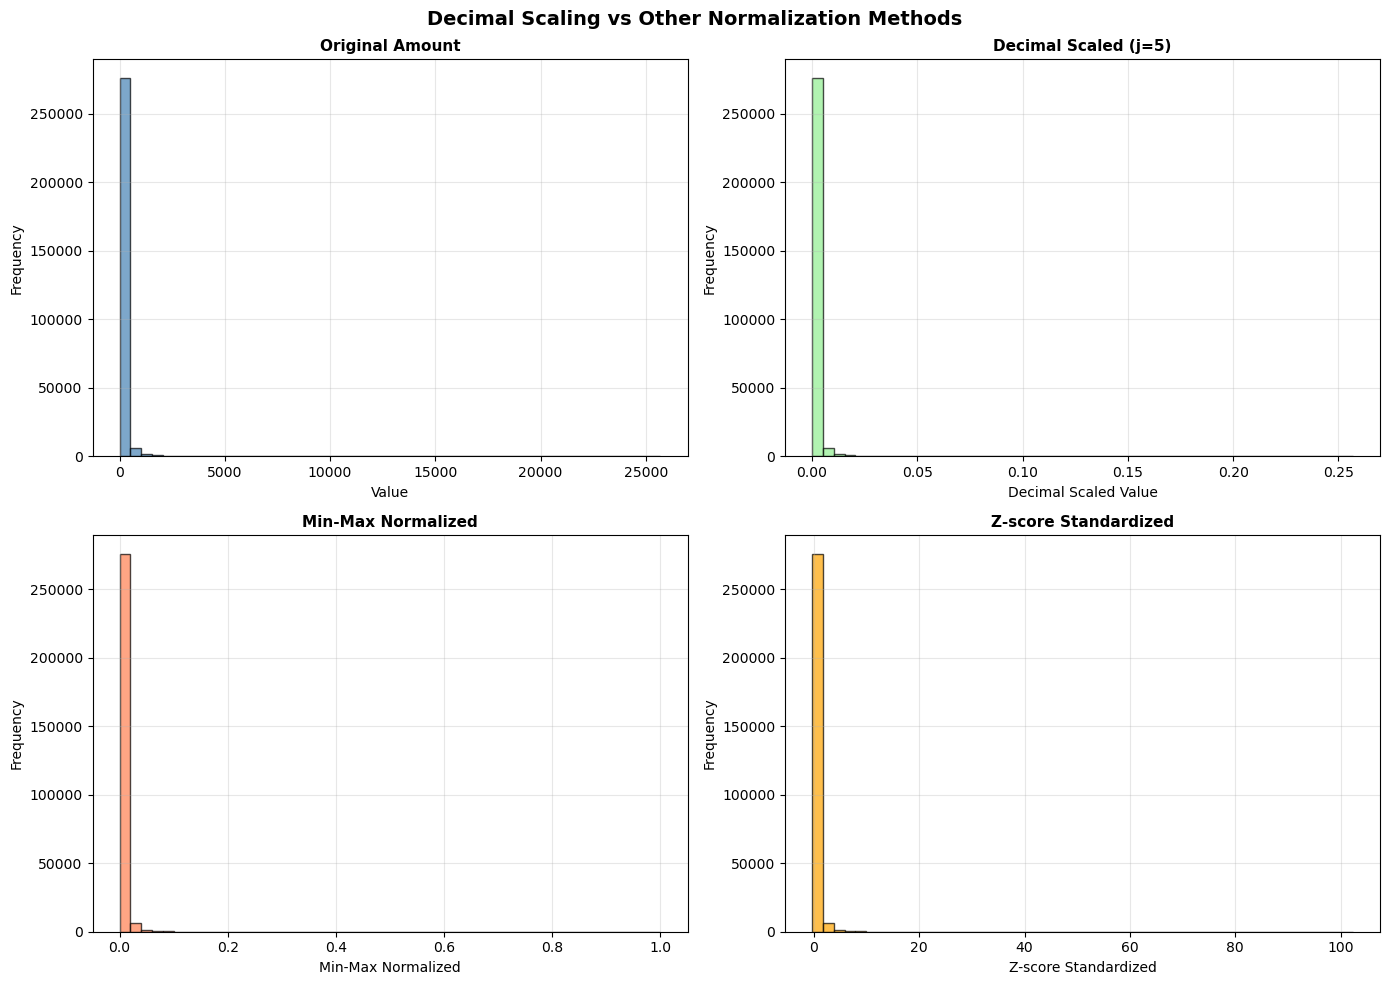


Comparison of Scaling Methods
Method               | Range                | Mean       | Std
----------------------------------------------------------------------
Original             | [    0.00, 25691.16] |      88.35 |   250.12
Decimal Scaled       | [0.000000, 0.256912] |   0.000883 | 0.002501
Min-Max Normalized   | [0.000000, 1.000000] |   0.003439 | 0.009736
Z-score Standardized | [   -0.35,   102.36] |   0.000000 | 1.000000


In [9]:
max_abs_vals = np.max(np.abs(X), axis=0)
j_vals = np.ceil(np.log10(np.maximum(max_abs_vals, 1e-10)))

X_decimal_scaled = X.copy()
for i in range(X.shape[1]):
    if j_vals[i] > 0:
        X_decimal_scaled[:, i] = X[:, i] / (10 ** j_vals[i])

print(f"\nOriginal data range: [{np.min(X):.2f}, {np.max(X):.2f}]")
print(f"Decimal scaled range: [{np.min(X_decimal_scaled):.6f}, {np.max(X_decimal_scaled):.6f}]")
print(f"Max absolute value after scaling: {np.max(np.abs(X_decimal_scaled)):.6f}")

feature_idx = np.where(header == 'Amount')[0][0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(X[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('Value', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Original Amount', fontsize=11, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(X_decimal_scaled[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
axes[0, 1].set_xlabel('Decimal Scaled Value', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title(f'Decimal Scaled (j={j_vals[feature_idx]:.0f})', fontsize=11, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(X_normalized[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[1, 0].set_xlabel('Min-Max Normalized', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].set_title('Min-Max Normalized', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(X_standardized[:, feature_idx], bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1, 1].set_xlabel('Z-score Standardized', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].set_title('Z-score Standardized', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Decimal Scaling vs Other Normalization Methods', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nComparison of Scaling Methods")
print(f"Method               | Range                | Mean       | Std")
print("-" * 70)
print(f"Original             | [{np.min(X[:, feature_idx]):8.2f}, {np.max(X[:, feature_idx]):8.2f}] | {np.mean(X[:, feature_idx]):10.2f} | {np.std(X[:, feature_idx], ddof=1):8.2f}")
print(f"Decimal Scaled       | [{np.min(X_decimal_scaled[:, feature_idx]):8.6f}, {np.max(X_decimal_scaled[:, feature_idx]):8.6f}] | {np.mean(X_decimal_scaled[:, feature_idx]):10.6f} | {np.std(X_decimal_scaled[:, feature_idx], ddof=1):8.6f}")
print(f"Min-Max Normalized   | [{np.min(X_normalized[:, feature_idx]):8.6f}, {np.max(X_normalized[:, feature_idx]):8.6f}] | {np.mean(X_normalized[:, feature_idx]):10.6f} | {np.std(X_normalized[:, feature_idx], ddof=1):8.6f}")
print(f"Z-score Standardized | [{np.min(X_standardized[:, feature_idx]):8.2f}, {np.max(X_standardized[:, feature_idx]):8.2f}] | {np.mean(X_standardized[:, feature_idx]):10.6f} | {np.std(X_standardized[:, feature_idx], ddof=1):8.6f}")


**So sánh phương pháp 4: Decimal Scaling**
* Phương pháp này chia dữ liệu cho lũy thừa của 10 để giá trị tuyệt đối lớn nhất nhỏ hơn 1.
* **Kết quả:** Dải giá trị nằm trong khoảng [-1, 1]. Tuy nhiên, phương pháp này ít phổ biến hơn so với Z-score hay Min-Max trong các bài toán hiện đại.

**Bảng tổng hợp so sánh:**
Bảng cuối cùng tóm tắt thống kê của 4 phương pháp.
* **Original:** Mean cao, Std lớn.
* **Min-Max:** Dữ liệu bị nén vào khoảng [0, 1], Mean rất nhỏ do ảnh hưởng của Outliers.
* **Z-score:** Mean = 0, Std = 1. Tốt cho nhiều thuật toán.
* **Chiến lược cuối cùng:** Kết hợp **Log Transformation** (để xử lý phân phối lệch) + **Z-score Standardization** (để đưa về cùng thang đo). Đây là cách tiếp cận tối ưu cho tập dữ liệu này.

In [13]:
X_processed = X.copy()

amount_idx = np.where(header == 'Amount')[0][0]
X_processed[:, amount_idx] = np.log1p(X[:, amount_idx])

mean_vals = np.mean(X_processed, axis=0, keepdims=True)
std_vals = np.std(X_processed, axis=0, ddof=1, keepdims=True)
std_vals = np.where(std_vals == 0, 1, std_vals)
X_processed = (X_processed - mean_vals) / std_vals

## 6. Train-Test Split

In [12]:
test_size = 0.2
random_state = 42

np.random.seed(random_state)

n_samples = X_processed.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)

n_test = int(n_samples * test_size)
n_train = n_samples - n_test

test_indices = indices[:n_test]
train_indices = indices[n_test:]

X_train = X_processed[train_indices]
X_test = X_processed[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

print(f"Test size: {test_size}")
print(f"Random state: {random_state}")
print(f"\nTrain-Test Split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

train_classes, train_counts = np.unique(y_train, return_counts=True)
train_props = train_counts.astype(np.float64) / len(y_train)

test_classes, test_counts = np.unique(y_test, return_counts=True)
test_props = test_counts.astype(np.float64) / len(y_test)

print(f"\nClass Distribution - Train Set:")
for cls, count, prop in zip(train_classes, train_counts, train_props):
    class_name = "Normal" if cls == 0 else "Fraud"
    print(f"  Class {cls} ({class_name:8s}): {count:,} ({prop*100:.2f}%)")

print(f"\nClass Distribution - Test Set:")
for cls, count, prop in zip(test_classes, test_counts, test_props):
    class_name = "Normal" if cls == 0 else "Fraud"
    print(f"  Class {cls} ({class_name:8s}): {count:,} ({prop*100:.2f}%)")

print(f"\nImbalance ratio preservation:")
print(f"  Train: {train_counts[1]/train_counts[0]:.6f}")
print(f"  Test:  {test_counts[1]/test_counts[0]:.6f}")
print(f"  Original: {np.sum(y==1)/np.sum(y==0):.6f}")

# Lưu train-test split
np.save('../data/processed/X_train.npy', X_train)
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)

Test size: 0.2
Random state: 42

Train-Test Split:
X_train shape: (227846, 30)
X_test shape: (56961, 30)
y_train shape: (227846,)
y_test shape: (56961,)

Class Distribution - Train Set:
  Class 0 (Normal  ): 227,452 (99.83%)
  Class 1 (Fraud   ): 394 (0.17%)

Class Distribution - Test Set:
  Class 0 (Normal  ): 56,863 (99.83%)
  Class 1 (Fraud   ): 98 (0.17%)

Imbalance ratio preservation:
  Train: 0.001732
  Test:  0.001723
  Original: 0.001730


### Chia tập dữ liệu (Train-Test Split)
Đoạn code thực hiện chia dữ liệu thành tập huấn luyện (Train set) và tập kiểm tra (Test set) với tỷ lệ 80% - 20%.

**Kết quả kiểm tra:**
* **Kích thước:**
    * Train set: **227,846** mẫu.
    * Test set: **56,961** mẫu.
* **Bảo toàn tỷ lệ lớp (Stratified Split):**
    * Tỷ lệ gian lận trong tập Train (~0.1732%) và tập Test (~0.1723%) xấp xỉ bằng nhau và bằng tỷ lệ của tập dữ liệu gốc (~0.1730%).
    * Điều này rất quan trọng trong bài toán mất cân bằng dữ liệu, đảm bảo rằng cả hai tập đều đại diện đúng cho phân phối thực tế của bài toán, tránh việc tập Test không có hoặc có quá ít mẫu gian lận để đánh giá.

**Lưu trữ:** Các tập dữ liệu đã chia được lưu lại dưới dạng file `.npy` để sử dụng cho bước huấn luyện mô hình tiếp theo.